In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Load specific forecasting tools
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df = pd.read_csv('dataset/full_COA.csv.' , index_col='Time',parse_dates=True)
df.head()

,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,
2012-01-01 01:00:00,5986.0,13.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 02:00:00,5547.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 03:00:00,5233.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 04:00:00,5150.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 05:00:00,5235.0,11.98,2012,1,1,1,0,0,0,0,0,0,1


In [3]:
df.index.freq = 'H'

In [4]:
df.tail()

,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,
2017-12-31 19:00:00,9495.0,18.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 20:00:00,9365.0,16.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 21:00:00,9250.0,15.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 22:00:00,8931.0,14.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 23:00:00,8679.0,12.98,2017,4,12,31,0,0,0,0,0,0,1


In [5]:
df_l = df[['COA']]

In [6]:
len(df_l)

52607

In [7]:
df_d = df_l['COA'].resample(rule = 'D').max()

In [8]:
df_d.index.freq = 'D'

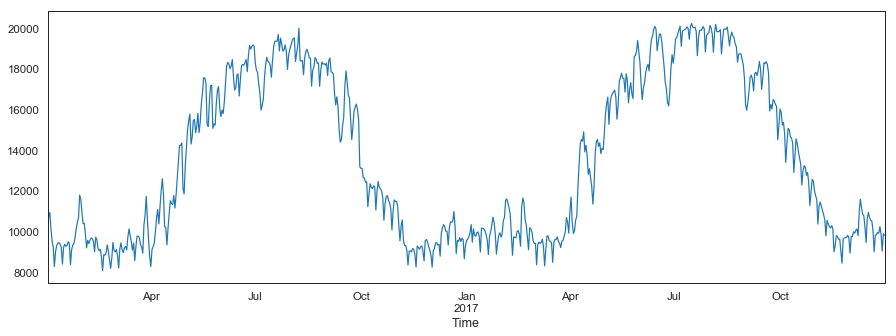

In [9]:
df_d['2016-01-01 01:00:00':].plot(figsize=(15,5)).autoscale(axis='x',tight=True)

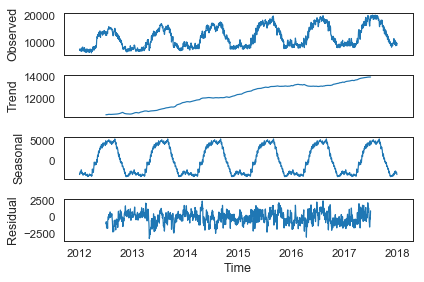

In [10]:
seasonal_decompose(df_d, freq=365).plot();

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [12]:
adf_test(df_d)

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.143328
p-value                    0.023508
# lags used               22.000000
# observations          2169.000000
critical value (1%)       -3.433368
critical value (5%)       -2.862873
critical value (10%)      -2.567480
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [13]:
l_df = len(df_d['2012-01-01 01:00:00':])

In [14]:
l_split = len(df_d['2017-01-01 00:00:00':])

In [15]:
l_df

2191

In [16]:
l_split

365

In [17]:
dataset = df_d.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)
train_size = l_df-l_split
test_size = len(dataset) - train_size
train, test = scaler.fit_transform(dataset[0:train_size,:]), scaler.transform(dataset[train_size:len(dataset),:])

In [18]:
l_df-l_split

1826

In [19]:
train_size

1826

In [20]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [21]:
len(train)

1826

In [22]:
len(test)

366

In [23]:
# reshape into X=t and Y=t+1
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [24]:
X_train.shape

(1824, 1)

In [25]:
Y_train.shape

(1824,)

In [26]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [27]:
model = Sequential()
model.add(LSTM(160, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=30, batch_size=40, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 1824 samples, validate on 364 samples
Epoch 1/30
1824/1824 [==============================] - 1s 307us/step - loss: 0.0593 - val_loss: 0.0234
Epoch 2/30
1824/1824 [==============================] - 0s 81us/step - loss: 0.0242 - val_loss: 0.0078
Epoch 3/30
1824/1824 [==============================] - 0s 76us/step - loss: 0.0092 - val_loss: 0.0023
Epoch 4/30
1824/1824 [==============================] - 0s 77us/step - loss: 0.0053 - val_loss: 0.0021
Epoch 5/30
1824/1824 [==============================] - 0s 75us/step - loss: 0.0051 - val_loss: 0.0020
Epoch 6/30
1824/1824 [==============================] - 0s 79us/step - loss: 0.0052 - val_loss: 0.0021
Epoch 7/30
1824/1824 [==============================] - 0s 75us/step - loss: 0.0050 - val_loss: 0.0019
Epoch 8/30
1824/1824 [==============================] - 0s 75us/step - loss: 0.0049 - val_loss: 0.0019
Epoch 9/30
1824/1824 [==============================] - 0s 72us/step - loss: 0.0046 - val_loss: 0.0019
Epoch 10/30
1824/1824 [==

In [28]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

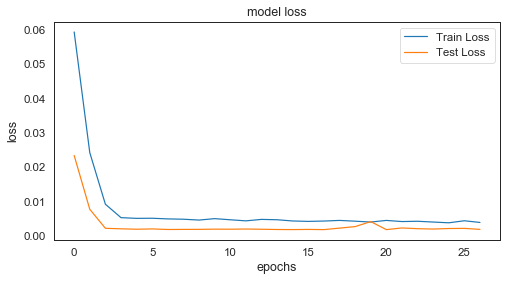

In [29]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

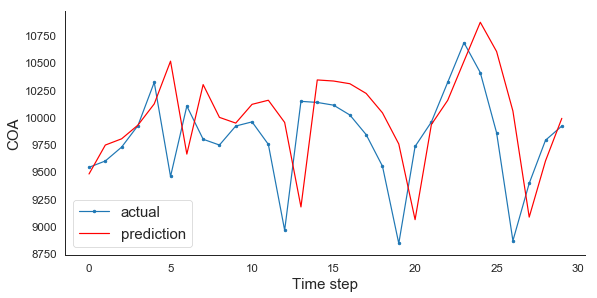

In [30]:
aa=[x for x in range(30)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:30], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:30], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('COA', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
# plt.ylim(0,10000)
plt.show();


In [31]:
Y_test.shape

(1, 364)

In [32]:
test_predict.shape

(364, 1)

In [33]:
Y_train.shape

(1, 1824)

In [34]:
tes = pd.DataFrame(Y_test.reshape(Y_test.shape[1],Y_test.shape[0]) , columns=['test'] , index= df_d.iloc[train_size+look_back:-1].index)

In [35]:
pre = pd.DataFrame(test_predict , columns=['pred'] , index= df_d.iloc[train_size+look_back:-1].index)

In [36]:
# df_d['2016-01-01 00:00:00':'2017-01-01 00:00:00'].plot(figsize=(12,8))

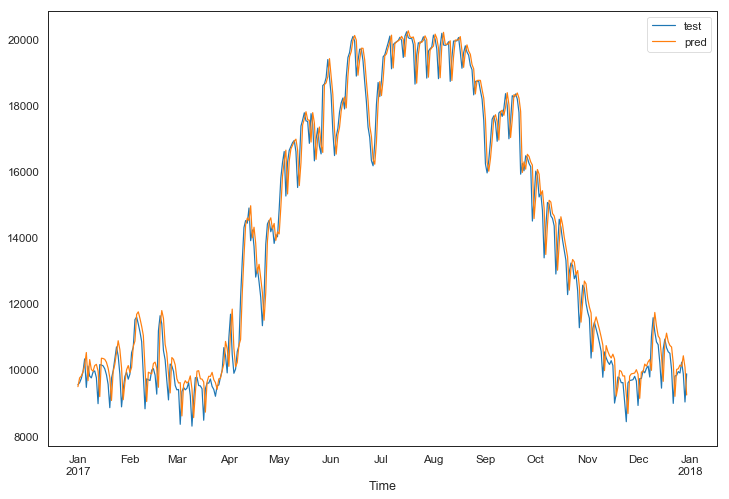

In [37]:
# df_d['2017-01-01 00:00:00':].plot( figsize=(12,8) , legend=True)
# y_t.train['2012-01-01 00:00:00':'2012-02-01 00:00:00'].plot(legend=True)
tes.test['2017-01-01 00:00:00':].plot(legend=True, figsize=(12,8))
pre.pred['2017-01-01 00:00:00':].plot(legend=True)

In [38]:
rmse(tes.test , pre.pred)

601.2465208993204

In [ ]:
r2_score(tes.test , pre.pred)

In [39]:
tes.test.mean()

14017.655575200935

In [40]:
pre.pred.mean()

14130.008